In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import seaborn as sns
import openpyxl as px
import os

def export_excel(_path=None, _df=None, _wb=None, _sheet_name='sheet1', _letter_fmt=None, _append=False, _frz='B2', _auto_flt=True, _auto_sz=False, _header_height=None, _col_width_=[20,20], _header_fmt=None, _header_rot=0, _zoom=100, _heatmap=0, _is_index=True, _index_name='Index', _header_txtcol='000000', _header_fillcol='d9f2f8', _txtwrap=False, _img=None, _group=None):
    import os
    import time
    import openpyxl as px
    from openpyxl.utils import get_column_letter
    from openpyxl.comments import Comment

    time_start = time.perf_counter()

    print('[Exporting Excel file ...] Sheet : "{0}"'.format(_sheet_name))
    
    #-------------------------------------------
    # 初期設定
    #-------------------------------------------
    # Workbook作成
    if _wb == None:
        if _append: # 既存ファイルにシート追加
            try:
                wb = px.load_workbook(_path)
            except:
                _append = False # ファイルが存在しないときは新規作成
        if not _append: # 新規ファイル
            wb = px.Workbook()
    else:
        wb = _wb
        _append = True
    # Worksheet作成
    ws = wb.create_sheet(title=_sheet_name)

    #-------------------------------------------
    # DataFrameをWorksheetに書き込み
    #-------------------------------------------
    if _df is not None:
        #----- 作業用にDataFrameをコピー -----
        df = _df.copy()
    
        # Timestampを文字列に変換（そのままだとエラーになるので）
        list_timestamp_col = list()
        # Timestampのセルが存在する列を探して文字列に変換する
        for col_name, col in df.iteritems():
            for item in col:
                tp = type(item)
                if tp is pd._libs.tslibs.timestamps.Timestamp:
                    list_timestamp_col.append(col_name)
                    break
        for col in list_timestamp_col:
            df[col] = df[col].astype(str)
            df[col] = df[col].replace('NaT', '')
    
        #----- Excelファイル用フォーマットの作成 -----
        base_font = '游ゴシック'
        from openpyxl.styles.fonts import Font
        from openpyxl.styles import PatternFill
        font_header_row = Font(name=base_font, b=True, sz=10, color=_header_txtcol)
        font_header_col = Font(name=base_font, b=True, sz=10, color=_header_txtcol)
        font_cell = Font(name=base_font, sz=10)
        align_header_row = px.styles.Alignment(horizontal="center", vertical="center", wrapText=True, textRotation=_header_rot)
        align_header_col = px.styles.Alignment(horizontal="center", vertical="center", wrapText=True)
        fill_header_row = PatternFill(patternType='solid', fgColor=_header_fillcol)
        fill_header_col = PatternFill(patternType='solid', fgColor=_header_fillcol)
    
        #----- データ出力 -----
        # DataFrameをWorksheetにExport
        l = df.columns.tolist()
        if _is_index:
            l.insert(0, _index_name) # 行のindexを先頭列に追加
        ws.append(l)
        count = 0
        for i, row in df.iterrows(): # 一行ずつwsに追加していく
            l = row.values.tolist()
            if _is_index:
                l.insert(0, row.name) # 行のindexを先頭列に追加
            ws.append(l)
            count += 1
            print('\r  - データコピー {0}/{1}'.format(count, len(df)), end="")
        print('')
    
        #-----  Worksheetの書式設定 -----
        # ヘッダー行(既定値)
        for cell in list(ws.rows)[0]:
            cell.font = font_header_row
            cell.alignment = align_header_row
            cell.fill = fill_header_row
        # ヘッダー行(個別)
        if _header_fmt != None:
            list_cell = list(ws.rows)[0]
            for head, fmt in _header_fmt.items():
                try:
                    index = list(df.columns).index(head)
                    if _is_index:
                        index += 1
                    cell = list_cell[index]
                except:
                    continue
                # rotation
                try:
                    rotation = fmt['rotation']
                    cell.alignment = px.styles.Alignment(horizontal="center", vertical="center", wrapText=True, textRotation=rotation)
                except:
                    pass
                # 文字色
                try:
                    text_color = fmt['txtcol']
                    cell.font = Font(name=base_font, b=True, sz=10, color=text_color)
                except:
                    pass
                # 背景色
                try:
                    fill_color = fmt['fillcol']
                    cell.fill = PatternFill(patternType='solid', fgColor=fill_color)
                except:
                    pass
                # コメント
                try:
                    comment = fmt['comment']
                    cell.comment  = Comment(comment, '')
                except:
                    pass
        # 列ごとの書式設定用のリスト作成
        list_dtxt_pat = list()
        list_dfill_pat = list()
        if _header_fmt != None:
            for head, fmt in _header_fmt.items():
                try:
                    index = list(df.columns).index(head)
                    if _is_index:
                        index += 1
                except:
                    continue
                # 文字色
                try:
                    text_color = fmt['dtxtcol']
                    list_dtxt_pat.append([index, Font(name=base_font, sz=10, color=text_color)])
                except:
                    pass
                # 背景色
                try:
                    dfill_color = fmt['dfillcol']
                    list_dfill_pat.append([index, PatternFill(patternType='solid', fgColor=dfill_color)])
                except:
                    pass
        # データ行書式設定
        count = 0
        for row in ws.iter_rows(min_row=2): 
            # 書式設定
            for cell in row:
                cell.font = font_cell
                cell.alignment = px.styles.Alignment(wrapText=_txtwrap)
            # 列ごとの書式設定で上書き
            for list_pat in list_dtxt_pat: # 個別設定がある列を順に処理する
                idx = list_pat[0]
                row[idx].font = list_pat[1]
            for list_pat in list_dfill_pat: # 個別設定がある列を順に処理する
                idx = list_pat[0]
                row[idx].fill = list_pat[1]
            # Index列がある場合はIndex用設定
            if _is_index:
                row[0].font = font_header_col # 先頭列のみ太字
                row[0].alignment = align_header_col # 先頭列のみセンタリング
                row[0].fill = fill_header_col # 先頭列の塗りつぶし
            count += 1
            print('\r  - 書式設定 {0}/{1}'.format(count, len(df)), end="")
        print('')
    
        #----- セルの文字書式 -----
        if type(_letter_fmt) is dict: # _header_fmtがあれば不要だが互換性のために残してある
            for col in ws.iter_cols():
                col_name = col[0].value
                if col_name in _letter_fmt:
                    num_format = _letter_fmt[col_name]
                    for cell in col:
                        cell.number_format = num_format
        elif type(_letter_fmt) is str:
            for col in ws.iter_cols():
                for cell in col:
                    cell.number_format = _letter_fmt
        # 列ごとの個別設定で上書き                
        if _header_fmt != None:
            list_col = list(_header_fmt.keys())
            for col in ws.iter_cols():
                col_name = col[0].value
                if col_name in list_col: # 列書式一覧の辞書にこの列が存在する
                    try:
                        fmt = _header_fmt[col_name]
                        num_format = fmt['dtxtformat']
                        for cell in col:
                            cell.number_format = num_format
                    except:
                        pass
       
        # Worksheetの列幅調整
        if _auto_sz: # 自動調整
            for col in ws.columns:
                max_length = 0
                column = col[0].column
                column = get_column_letter(column) # 数字をアルファベットに変換
                cols = col if _header_rot!=90 else col[1:]
                for cell in cols:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                adjusted_width = (max_length + 2) * 1.1
                ws.column_dimensions[column].width = adjusted_width
        else:
            for col in ws.columns:
                column = col[0].column # 列番号を取得
                col_letter = get_column_letter(column) # 列番号を列記号に変換
                width = _col_width_[0] if column == 1 else _col_width_[1] # 列幅
                ws.column_dimensions[col_letter].width = width
        # 列ごとの個別調整
        if _header_fmt != None:
            list_col = list(ws.columns)
            for head, fmt in _header_fmt.items():
                try:
                    width = fmt['width']
                    index = list(df.columns).index(head)
                    if _is_index:
                        index += 1
                    col = list_col[index]
                    column = col[0].column # 列番号を取得
                    col_letter = get_column_letter(column) # 列番号を列記号に変換
                    ws.column_dimensions[col_letter].width = width
                except:
                    pass
    
        # Worksheetの行の高さ調整
        if _header_height != None:
            ws.row_dimensions[1].height = _header_height
    
        # ヒートマップ
        from openpyxl.formatting.rule import ColorScale, FormatObject
        from openpyxl.styles import Color
        if _heatmap == 1: # 赤 → 白 → 青
            first = FormatObject(type='min')
            last = FormatObject(type='max')
            # colors match the format objects:
            colors = [Color('F8696B'), Color('5A8AC6')]
            # a three color scale would extend the sequences
            mid = FormatObject(type='percentile', val=50)
            colors.insert(1, Color('FCFCFF'))
            cs3 = ColorScale(cfvo=[first, mid, last], color=colors)
            # create a rule with the color scale
            from openpyxl.formatting.rule import Rule
            rule = Rule(type='colorScale', colorScale=cs3)
            # 対象範囲を示す文字列を作成
            rg = 'A2:' + get_column_letter(ws.max_column)+str(ws.max_row)
            ws.conditional_formatting.add(rg, rule)
        elif _heatmap == 2: # 白 → 橙 → 赤
            first = FormatObject(type='min')
            last = FormatObject(type='max')
            # colors match the format objects:
            colors = [Color('FFFFFF'), Color('F8696B')]
            # a three color scale would extend the sequences
            mid = FormatObject(type='percentile', val=50)
            colors.insert(1, Color('FFEB84'))
            cs3 = ColorScale(cfvo=[first, mid, last], color=colors)
            # create a rule with the color scale
            from openpyxl.formatting.rule import Rule
            rule = Rule(type='colorScale', colorScale=cs3)
            # 対象範囲を示す文字列を作成
            rg = 'A2:' + get_column_letter(ws.max_column)+str(ws.max_row)
            ws.conditional_formatting.add(rg, rule)
        elif _heatmap == 3: # 赤 → 橙 → 白
            first = FormatObject(type='min')
            last = FormatObject(type='max')
            # colors match the format objects:
            colors = [Color('F8696B'), Color('FFFFFF')]
            # a three color scale would extend the sequences
            mid = FormatObject(type='percentile', val=25)
            colors.insert(1, Color('FFEB84'))
            cs3 = ColorScale(cfvo=[first, mid, last], color=colors)
            # create a rule with the color scale
            from openpyxl.formatting.rule import Rule
            rule = Rule(type='colorScale', colorScale=cs3)
            # 対象範囲を示す文字列を作成
            rg = 'A2:' + get_column_letter(ws.max_column)+str(ws.max_row)
            ws.conditional_formatting.add(rg, rule)
            
        # 枠固定
        if _frz != None:
            ws.freeze_panes = _frz

        # オートフィルタ
        if _auto_flt:
            ws.auto_filter.ref = 'A1:' + get_column_letter(ws.max_column)+'1'
    
        # グループ化([0]開始列名 [1]終了列名 [2]閉じる時True)
        if _group != None:
            for r in _group:
                if r[0] < r[1]:
                    ws.column_dimensions.group(get_column_letter(r[0]), get_column_letter(r[1]), hidden=r[2])
    
    # 表示倍率
    ws.sheet_view.zoomScale = _zoom
        
    #-------------------------------------------
    # Worksheetに画像を挿入
    #-------------------------------------------
    if _img != None:
        from openpyxl.drawing.image import Image
        for img in _img:
            fpath = img[0] # 挿入する画像ファイル
            anchor = img[1] # 挿入位置
            px_img = Image(fpath)
            px_img.anchor = anchor
            ws.add_image(px_img)
    
    #-------------------------------------------
    # 最後に不要なシートを削除
    #-------------------------------------------
    if 'Sheet' in wb.sheetnames:
        wb.remove(wb['Sheet'])

    #-------------------------------------------
    # Excelファイルに書き込み
    #-------------------------------------------
    if _path != None:
        print('  - ファイル書き込み...', end='')
        wb.save(_path)
        # 画像ファイル削除
        if _img != None:
            for img in _img:
                is_delete = False # ファイルを削除するか否か
                if len(img) > 2:
                    is_delete = img[2]
                if is_delete: # ファイル削除
                    os.remove(img[0])

    print ('\n   ---> Finished. (処理時間:{0:.3f}[sec])'.format(time.perf_counter() - time_start ))
    
    return wb

ファイルの読み込み

In [2]:
preference_path = r"C:\Users\e13971\Downloads\射出結果.xlsx"
preference_df = pd.read_excel(preference_path)
preference_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ヘッド番号,検査ID,検査日時,検査装置No,合否判定
1,XA0002704,1812115,2019-02-05 19:43:29,20,その他NG
2,XA1002113,1812285,2019-02-06 09:28:52,20,合格
3,XA1002104,1812344,2019-02-06 09:48:43,20,合格
4,XA1002111,1812389,2019-02-06 10:08:37,20,合格
...,...,...,...,...,...
6406,XA1103510,1933578,2019-07-17 14:30:38,22,合格
6407,XA1103505,1933585,2019-07-17 14:33:31,25,合格
6408,XA1103519,1933591,2019-07-17 14:36:54,20,合格
6409,XA1103509,1933599,2019-07-17 14:39:25,11,合格


In [3]:
preference_df = preference_df.iloc[1:,:]
preference_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
1,XA0002704,1812115,2019-02-05 19:43:29,20,その他NG
2,XA1002113,1812285,2019-02-06 09:28:52,20,合格
3,XA1002104,1812344,2019-02-06 09:48:43,20,合格
4,XA1002111,1812389,2019-02-06 10:08:37,20,合格
5,XA1002114,1812494,2019-02-06 10:51:02,20,合格
...,...,...,...,...,...
6406,XA1103510,1933578,2019-07-17 14:30:38,22,合格
6407,XA1103505,1933585,2019-07-17 14:33:31,25,合格
6408,XA1103519,1933591,2019-07-17 14:36:54,20,合格
6409,XA1103509,1933599,2019-07-17 14:39:25,11,合格


In [4]:
#カラム名を変更
preference_df.columns = ["ヘッド番号","検査ID","検査日時","検査装置No","合否判定"]
preference_df

,ヘッド番号,検査ID,検査日時,検査装置No,合否判定
1,XA0002704,1812115,2019-02-05 19:43:29,20,その他NG
2,XA1002113,1812285,2019-02-06 09:28:52,20,合格
3,XA1002104,1812344,2019-02-06 09:48:43,20,合格
4,XA1002111,1812389,2019-02-06 10:08:37,20,合格
5,XA1002114,1812494,2019-02-06 10:51:02,20,合格
...,...,...,...,...,...
6406,XA1103510,1933578,2019-07-17 14:30:38,22,合格
6407,XA1103505,1933585,2019-07-17 14:33:31,25,合格
6408,XA1103519,1933591,2019-07-17 14:36:54,20,合格
6409,XA1103509,1933599,2019-07-17 14:39:25,11,合格


欠損値、重複データを調べる

In [38]:
wafer_path = r"C:\Users\e13971\Downloads\ウエハ容量.xlsx"
wafer_df = pd.read_excel(wafer_path)
wafer_df

,ウエハID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散
0,X10002,10443.600,10809.800,366.200,10660.170117,10800.7250,10586.6950,10635.3750,10801.15,10645.100,10593.15,68.741052,4725.332242
1,X10003,10675.550,10923.300,247.750,10762.297656,10901.2650,10719.1900,10731.4000,10903.95,10687.050,10710.35,66.136558,4374.044350
2,X10004,10903.850,11107.150,203.300,11018.263867,11040.7100,10962.7200,11019.2500,11019.30,10995.050,10977.35,38.346220,1470.432591
3,X10005,10656.100,10952.650,296.550,10849.795117,10880.4600,10747.4300,10863.7000,10876.45,10880.550,10745.20,47.551432,2261.138697
4,X10006,10334.950,10906.350,571.400,10830.605664,10780.8350,10767.5800,10834.2250,10773.60,10886.450,10815.15,48.135113,2316.989138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,X11396,9551.890,9737.515,185.625,9663.573418,9604.8060,9590.3890,9670.1275,9602.59,9690.635,9645.60,42.276196,1787.276758
755,X11397,9344.765,9653.105,308.340,9514.994023,9496.4555,9439.4715,9520.2850,9484.60,9536.990,9468.42,39.852884,1588.252345
756,X11398,9354.200,9524.900,170.700,9480.465820,9442.0225,9420.4485,9488.2525,9433.67,9486.095,9459.46,26.984803,728.179611
757,X11399,9405.195,9566.650,161.455,9524.424082,9540.7190,9428.4455,9536.5375,9546.80,9526.515,9449.21,35.505551,1260.644166


In [39]:
drop_index = wafer_df.index[
  (wafer_df["3_ウエハ容量最小値"] == 0) |
  (wafer_df["3_ウエハ容量最大値"] < 2000) |
  (wafer_df["3_ウエハ容量最大値"] > 20000) |
  (wafer_df["3_ウエハ容量レンジ"] > 1000) |
  (wafer_df["3_ウエハ容量平均値"] == 0) |
  (wafer_df["3_ウエハ容量1~10ch平均値"] == 0) |
  (wafer_df["3_ウエハ容量247~256ch平均値"] == 0) |
  (wafer_df["3_ウエハ容量中央値"] == 0) |
  (wafer_df["3_ウエハ容量チャンネル001"] == 0) |
  (wafer_df["3_ウエハ容量チャンネル128"] == 0) |
  (wafer_df["3_ウエハ容量チャンネル256"] == 0) |
  (wafer_df["3_ウエハ容量標準偏差"] > 200) |
  (wafer_df["3_ウエハ容量分散"] > 20000)
  ]
wafer_df = wafer_df.drop(drop_index)
wafer_df

,ウエハID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散
0,X10002,10443.600,10809.800,366.200,10660.170117,10800.7250,10586.6950,10635.3750,10801.15,10645.100,10593.15,68.741052,4725.332242
1,X10003,10675.550,10923.300,247.750,10762.297656,10901.2650,10719.1900,10731.4000,10903.95,10687.050,10710.35,66.136558,4374.044350
2,X10004,10903.850,11107.150,203.300,11018.263867,11040.7100,10962.7200,11019.2500,11019.30,10995.050,10977.35,38.346220,1470.432591
3,X10005,10656.100,10952.650,296.550,10849.795117,10880.4600,10747.4300,10863.7000,10876.45,10880.550,10745.20,47.551432,2261.138697
4,X10006,10334.950,10906.350,571.400,10830.605664,10780.8350,10767.5800,10834.2250,10773.60,10886.450,10815.15,48.135113,2316.989138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,X11396,9551.890,9737.515,185.625,9663.573418,9604.8060,9590.3890,9670.1275,9602.59,9690.635,9645.60,42.276196,1787.276758
755,X11397,9344.765,9653.105,308.340,9514.994023,9496.4555,9439.4715,9520.2850,9484.60,9536.990,9468.42,39.852884,1588.252345
756,X11398,9354.200,9524.900,170.700,9480.465820,9442.0225,9420.4485,9488.2525,9433.67,9486.095,9459.46,26.984803,728.179611
757,X11399,9405.195,9566.650,161.455,9524.424082,9540.7190,9428.4455,9536.5375,9546.80,9526.515,9449.21,35.505551,1260.644166


In [6]:
chip_path = r"C:\Users\e13971\Downloads\チップ容量.xlsx"
chip_df = pd.read_excel(chip_path)
chip_df

,チップID,LA_6_チップ容量最小値,LA_6_チップ容量最大値,LA_6_チップ容量レンジ,LA_6_チップ容量平均値,LA_6_チップ容量1~10ch平均値,LA_6_チップ容量247~256ch平均値,LA_6_チップ容量中央値,LA_6_チップ容量チャンネル001,LA_6_チップ容量チャンネル128,...,RB_6_チップ容量レンジ,RB_6_チップ容量平均値,RB_6_チップ容量1~10ch平均値,RB_6_チップ容量247~256ch平均値,RB_6_チップ容量中央値,RB_6_チップ容量チャンネル001,RB_6_チップ容量チャンネル128,RB_6_チップ容量チャンネル255,RB_6_チップ容量標準偏差,RB_6_チップ容量分散
0,X0002702,833.497009,859.030029,25.533020,851.096145,852.629700,845.830804,851.190521,846.911987,841.585022,...,18.608032,864.106910,868.072900,866.426105,863.753998,866.658020,857.268982,862.918030,2.870183,8.237953
1,X0002703,840.706970,865.202026,24.495056,858.258714,859.071210,854.743109,858.167999,855.500000,849.604004,...,14.831970,866.371633,871.148206,868.369800,866.190521,868.275024,859.906006,862.689026,3.268175,10.680967
2,X0002704,843.927002,871.390991,27.463989,864.212457,867.395599,861.512207,865.282501,864.078003,856.408997,...,19.213989,870.879711,877.769305,874.197498,870.625488,872.916016,865.763977,868.700989,3.368513,11.346877
3,X0002705,856.132019,876.187988,20.055969,869.054610,871.705298,864.102606,869.612000,869.474976,860.932983,...,17.074951,875.858632,879.342694,878.116907,876.056000,876.973999,867.817993,871.432007,3.296208,10.864990
4,X0002706,852.401978,870.961975,18.559998,865.372961,869.017896,860.140698,865.471985,866.817993,857.392029,...,28.825012,870.815669,872.505499,869.639404,871.036499,871.038025,863.090027,864.320007,2.981184,8.887455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,X1121225,900.140015,913.224976,13.084961,906.044948,903.952686,908.656799,905.337006,902.961975,900.140015,...,12.418945,924.187792,920.413696,927.496906,923.981995,918.929016,918.075989,923.307007,2.732025,7.463962
8928,X1121226,901.083008,916.629028,15.546021,909.457152,904.660309,909.212000,909.082520,903.340027,901.989990,...,12.889954,928.874381,925.199805,933.645197,928.785980,924.898987,923.585999,930.820007,2.850959,8.127968
8929,X1121227,894.931030,909.398010,14.466980,902.269301,896.914099,902.719598,902.081512,899.690002,895.627991,...,12.677979,923.263496,920.194397,926.486499,923.403992,919.210022,918.455017,921.023987,2.611065,6.817660
8930,X1121228,890.375977,907.486023,17.110046,898.391025,892.920801,901.084412,897.985992,895.557983,890.664001,...,14.364990,919.370296,917.680499,924.653894,918.882996,918.643005,914.966003,922.359985,2.986182,8.917284


In [20]:
chip_df = chip_df[chip_df["LA_6_チップ容量最小値"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量最小値"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量最大値"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量最大値"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量レンジ"] <= 200]
chip_df = chip_df[chip_df["LA_6_チップ容量平均値"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量平均値"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量1~10ch平均値"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量1~10ch平均値"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量247~256ch平均値"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量247~256ch平均値"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量中央値"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量中央値"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量チャンネル001"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量チャンネル001"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量チャンネル128"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量チャンネル128"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量チャンネル255"] >= 500]
chip_df = chip_df[chip_df["LA_6_チップ容量チャンネル255"] <= 1000]
chip_df = chip_df[chip_df["LA_6_チップ容量標準偏差"] <= 100]
chip_df = chip_df[chip_df["LA_6_チップ容量分散"] <= 1000]

chip_df = chip_df[chip_df["LB_6_チップ容量最小値"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量最小値"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量最大値"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量最大値"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量レンジ"] <= 200]
chip_df = chip_df[chip_df["LB_6_チップ容量平均値"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量平均値"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量1~10ch平均値"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量1~10ch平均値"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量247~256ch平均値"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量247~256ch平均値"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量中央値"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量中央値"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量チャンネル001"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量チャンネル001"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量チャンネル128"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量チャンネル128"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量チャンネル255"] >= 500]
chip_df = chip_df[chip_df["LB_6_チップ容量チャンネル255"] <= 1000]
chip_df = chip_df[chip_df["LB_6_チップ容量標準偏差"] <= 100]
chip_df = chip_df[chip_df["LB_6_チップ容量分散"] <= 1000]

chip_df = chip_df[chip_df["RA_6_チップ容量最小値"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量最小値"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量最大値"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量最大値"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量レンジ"] <= 200]
chip_df = chip_df[chip_df["RA_6_チップ容量平均値"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量平均値"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量1~10ch平均値"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量1~10ch平均値"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量247~256ch平均値"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量247~256ch平均値"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量中央値"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量中央値"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量チャンネル001"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量チャンネル001"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量チャンネル128"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量チャンネル128"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量チャンネル255"] >= 500]
chip_df = chip_df[chip_df["RA_6_チップ容量チャンネル255"] <= 1000]
chip_df = chip_df[chip_df["RA_6_チップ容量標準偏差"] <= 100]
chip_df = chip_df[chip_df["RA_6_チップ容量分散"] <= 1000]

chip_df = chip_df[chip_df["RB_6_チップ容量最小値"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量最小値"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量最大値"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量最大値"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量レンジ"] <= 200]
chip_df = chip_df[chip_df["RB_6_チップ容量平均値"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量平均値"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量1~10ch平均値"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量1~10ch平均値"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量247~256ch平均値"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量247~256ch平均値"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量中央値"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量中央値"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量チャンネル001"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量チャンネル001"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量チャンネル128"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量チャンネル128"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量チャンネル255"] >= 500]
chip_df = chip_df[chip_df["RB_6_チップ容量チャンネル255"] <= 1000]
chip_df = chip_df[chip_df["RB_6_チップ容量標準偏差"] <= 100]
chip_df = chip_df[chip_df["RB_6_チップ容量分散"] <= 1000]
chip_df

,チップID,LA_6_チップ容量最小値,LA_6_チップ容量最大値,LA_6_チップ容量レンジ,LA_6_チップ容量平均値,LA_6_チップ容量1~10ch平均値,LA_6_チップ容量247~256ch平均値,LA_6_チップ容量中央値,LA_6_チップ容量チャンネル001,LA_6_チップ容量チャンネル128,...,RB_6_チップ容量レンジ,RB_6_チップ容量平均値,RB_6_チップ容量1~10ch平均値,RB_6_チップ容量247~256ch平均値,RB_6_チップ容量中央値,RB_6_チップ容量チャンネル001,RB_6_チップ容量チャンネル128,RB_6_チップ容量チャンネル255,RB_6_チップ容量標準偏差,RB_6_チップ容量分散
0,X0002702,833.497009,859.030029,25.533020,851.096145,852.629700,845.830804,851.190521,846.911987,841.585022,...,18.608032,864.106910,868.072900,866.426105,863.753998,866.658020,857.268982,862.918030,2.870183,8.237953
1,X0002703,840.706970,865.202026,24.495056,858.258714,859.071210,854.743109,858.167999,855.500000,849.604004,...,14.831970,866.371633,871.148206,868.369800,866.190521,868.275024,859.906006,862.689026,3.268175,10.680967
2,X0002704,843.927002,871.390991,27.463989,864.212457,867.395599,861.512207,865.282501,864.078003,856.408997,...,19.213989,870.879711,877.769305,874.197498,870.625488,872.916016,865.763977,868.700989,3.368513,11.346877
3,X0002705,856.132019,876.187988,20.055969,869.054610,871.705298,864.102606,869.612000,869.474976,860.932983,...,17.074951,875.858632,879.342694,878.116907,876.056000,876.973999,867.817993,871.432007,3.296208,10.864990
4,X0002706,852.401978,870.961975,18.559998,865.372961,869.017896,860.140698,865.471985,866.817993,857.392029,...,28.825012,870.815669,872.505499,869.639404,871.036499,871.038025,863.090027,864.320007,2.981184,8.887455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,X1121225,900.140015,913.224976,13.084961,906.044948,903.952686,908.656799,905.337006,902.961975,900.140015,...,12.418945,924.187792,920.413696,927.496906,923.981995,918.929016,918.075989,923.307007,2.732025,7.463962
8928,X1121226,901.083008,916.629028,15.546021,909.457152,904.660309,909.212000,909.082520,903.340027,901.989990,...,12.889954,928.874381,925.199805,933.645197,928.785980,924.898987,923.585999,930.820007,2.850959,8.127968
8929,X1121227,894.931030,909.398010,14.466980,902.269301,896.914099,902.719598,902.081512,899.690002,895.627991,...,12.677979,923.263496,920.194397,926.486499,923.403992,919.210022,918.455017,921.023987,2.611065,6.817660
8930,X1121228,890.375977,907.486023,17.110046,898.391025,892.920801,901.084412,897.985992,895.557983,890.664001,...,14.364990,919.370296,917.680499,924.653894,918.882996,918.643005,914.966003,922.359985,2.986182,8.917284


In [41]:
preferenceid_df = preference_df.iloc[:,:1]
preferenceid_df[preferenceid_df.duplicated()]

,ヘッド番号


In [40]:
wafer_df[wafer_df.duplicated(subset="ウエハID")]

,ウエハID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散


In [42]:
chip_df[chip_df.duplicated(subset="チップID")]

,チップID,LA_6_チップ容量最小値,LA_6_チップ容量最大値,LA_6_チップ容量レンジ,LA_6_チップ容量平均値,LA_6_チップ容量1~10ch平均値,LA_6_チップ容量247~256ch平均値,LA_6_チップ容量中央値,LA_6_チップ容量チャンネル001,LA_6_チップ容量チャンネル128,...,RB_6_チップ容量レンジ,RB_6_チップ容量平均値,RB_6_チップ容量1~10ch平均値,RB_6_チップ容量247~256ch平均値,RB_6_チップ容量中央値,RB_6_チップ容量チャンネル001,RB_6_チップ容量チャンネル128,RB_6_チップ容量チャンネル255,RB_6_チップ容量標準偏差,RB_6_チップ容量分散


In [43]:
headno = preference_df["ヘッド番号"]
idno = []
widno = []
for no in headno:
  idno.append(no.replace("XA","X"))
chiplist = list(chip_df["チップID"])
for i in idno:
  if not(i in chiplist):
    print(i)

X0002504
X0002510
X0002501
X0002521
X0002509
X0002123
X0002121
X0002129
X1027113
X1027116
X1023522
X1031430
X1031907
X1031319
X1039415
X1042729
X1046427
X1071122
X1074317
X1055209
X1058129
X1059701
X1059715
X1078421
X1079213
X1079302
X1083620
X1083330
X1095226
X1095211
X1091111
X1087711
X1113214
X0006818
X0006117
X0006121
X0006828
X0006822
X0006112
X0006122
X0006126
X0006128
X0006816
X0006814
X0006824
X0006812
X0006522
X0006114
X0006515
X0006526
X0006124
X0006823
X0006524
X0006521
X0006116
X0006516
X0006826
X0006528
X0006513
X0006119
X0006518
X0006820
X0006520


In [56]:
headno = preference_df["ヘッド番号"]
chipid = []
waferid = []
for no in headno:
  chipid.append(no.replace("XA","X"))
  waferid.append(no[:-2].replace("XA","X"))
preference_df["チップID"] = chipid
preference_df["ウエハID"] = waferid
preference_df = preference_df.reindex(columns=['ヘッド番号', 'チップID', 'ウエハID', '検査ID', '検査日時', '検査装置No', '合否判定'])
preference_df

C:\Users\e13971\AppData\Local\Temp\ipykernel_27820\933500101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preference_df["チップID"] = chipid
C:\Users\e13971\AppData\Local\Temp\ipykernel_27820\933500101.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preference_df["ウエハID"] = waferid


,ヘッド番号,チップID,ウエハID,検査ID,検査日時,検査装置No,合否判定
1,XA0002704,X0002704,X00027,1812115,2019-02-05 19:43:29,20,その他NG
2,XA1002113,X1002113,X10021,1812285,2019-02-06 09:28:52,20,合格
3,XA1002104,X1002104,X10021,1812344,2019-02-06 09:48:43,20,合格
4,XA1002111,X1002111,X10021,1812389,2019-02-06 10:08:37,20,合格
5,XA1002114,X1002114,X10021,1812494,2019-02-06 10:51:02,20,合格
...,...,...,...,...,...,...,...
6406,XA1103510,X1103510,X11035,1933578,2019-07-17 14:30:38,22,合格
6407,XA1103505,X1103505,X11035,1933585,2019-07-17 14:33:31,25,合格
6408,XA1103519,X1103519,X11035,1933591,2019-07-17 14:36:54,20,合格
6409,XA1103509,X1103509,X11035,1933599,2019-07-17 14:39:25,11,合格


In [57]:
df = pd.merge(preference_df, chip_df, on="チップID", how="inner")
dffinal = pd.merge(df, wafer_df, on="ウエハID", how="inner")
dffinal

,ヘッド番号,チップID,ウエハID,検査ID,検査日時,検査装置No,合否判定,LA_6_チップ容量最小値,LA_6_チップ容量最大値,LA_6_チップ容量レンジ,...,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散
0,XA1002113,X1002113,X10021,1812285,2019-02-06 09:28:52,20,合格,880.950012,896.142029,15.192017,...,272.15,10810.480664,10903.280,10687.655,10797.35,10929.8,10792.75,10715.00,75.390536,5683.732878
1,XA1002104,X1002104,X10021,1812344,2019-02-06 09:48:43,20,合格,873.458984,895.859009,22.400024,...,272.15,10810.480664,10903.280,10687.655,10797.35,10929.8,10792.75,10715.00,75.390536,5683.732878
2,XA1002111,X1002111,X10021,1812389,2019-02-06 10:08:37,20,合格,870.364990,880.263000,9.898010,...,272.15,10810.480664,10903.280,10687.655,10797.35,10929.8,10792.75,10715.00,75.390536,5683.732878
3,XA1002114,X1002114,X10021,1812494,2019-02-06 10:51:02,20,合格,882.367004,896.418030,14.051025,...,272.15,10810.480664,10903.280,10687.655,10797.35,10929.8,10792.75,10715.00,75.390536,5683.732878
4,XA1002108,X1002108,X10021,1812684,2019-02-06 12:16:55,20,合格,870.942993,885.932983,14.989990,...,272.15,10810.480664,10903.280,10687.655,10797.35,10929.8,10792.75,10715.00,75.390536,5683.732878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,XA1090228,X1090228,X10902,1923698,2019-07-03 11:18:49,20,合格,894.234985,911.125977,16.890991,...,226.30,10874.077930,10820.775,10773.885,10890.25,10742.7,10899.80,10767.25,59.200280,3504.673175
3828,XA1090227,X1090227,X10902,1923748,2019-07-03 11:37:08,25,その他NG,899.995972,914.914001,14.918030,...,226.30,10874.077930,10820.775,10773.885,10890.25,10742.7,10899.80,10767.25,59.200280,3504.673175
3829,XA1090226,X1090226,X10902,1923762,2019-07-03 11:42:18,20,合格,900.148987,917.306030,17.157043,...,226.30,10874.077930,10820.775,10773.885,10890.25,10742.7,10899.80,10767.25,59.200280,3504.673175
3830,XA1090204,X1090204,X10902,1927316,2019-07-08 13:47:02,20,合格,909.187988,930.895996,21.708008,...,226.30,10874.077930,10820.775,10773.885,10890.25,10742.7,10899.80,10767.25,59.200280,3504.673175


In [59]:
len(dffinal.index)

3832

In [58]:
dffinal["合否判定"].value_counts(normalize=True)

合格       0.733038
速度うねり    0.162056
その他NG    0.104906
Name: 合否判定, dtype: float64

In [61]:
summary_file_path = r"C:\Users\e13971\Desktop\Data.xlsx"
export_excel(_path = summary_file_path, _df = dffinal, _sheet_name = "Data", _header_fillcol = "66ffcc")

[Exporting Excel file ...] Sheet : "Data"
  - データコピー 3832/3832
  - 書式設定 3832/3832
  - ファイル書き込み...
   ---> Finished. (処理時間:19.708[sec])


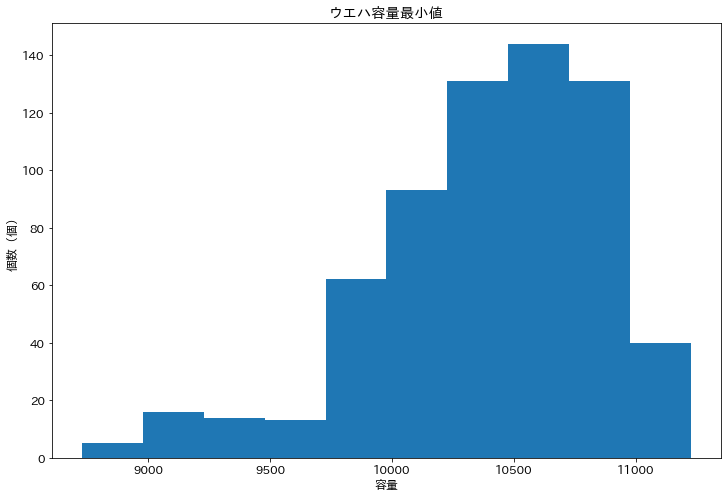

In [44]:
plt.figure(figsize = (12,8))
plt.rcParams["font.size"] = 12
plt.hist(wafer_df["3_ウエハ容量最小値"])
plt.title("ウエハ容量最小値")
plt.ylabel("個数（個）")
plt.xlabel("容量")
plt.show()

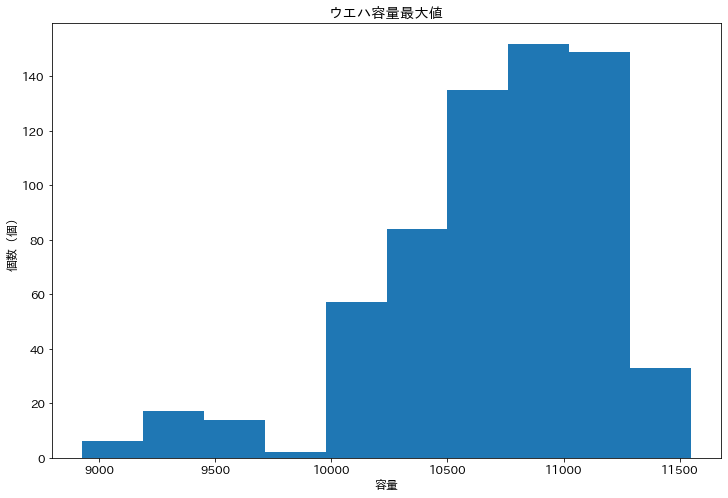

In [45]:
plt.figure(figsize = (12,8))
plt.rcParams["font.size"] = 12
plt.hist(wafer_df["3_ウエハ容量最大値"])
plt.title("ウエハ容量最大値")
plt.ylabel("個数（個）")
plt.xlabel("容量")
plt.show()